In [1]:
import sys

In [2]:
!{sys.executable} -m pip install scipy


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [4]:
stock_names = ['AAPL', 'ADBE', 'AMZN','BTC-USD', 'FB', 'GCF', 'IRX','MSFT', 'NVDA', 'QCOM','TSLA','TXN']
datasets_path = f"../dataset/historical_data/"
columns_to_drop = ['Dividends', 'Stock Splits']
datasets = []

In [5]:
for stock in stock_names:
    file_path = f"{datasets_path}{stock}.csv" 
    try:
        data = pd.read_csv(file_path)
        data_cleaned = data.drop(columns=columns_to_drop)
        data_cleaned = data_cleaned.dropna()
        datasets.append((stock, data_cleaned))
        print(f"Data for {stock} loaded successfully.")  
    except FileNotFoundError:
        print(f"File not found for stock: {stock} at path: {file_path}")

Data for AAPL loaded successfully.
Data for ADBE loaded successfully.
Data for AMZN loaded successfully.
Data for BTC-USD loaded successfully.
Data for FB loaded successfully.
Data for GCF loaded successfully.
Data for IRX loaded successfully.
Data for MSFT loaded successfully.
Data for NVDA loaded successfully.
Data for QCOM loaded successfully.
Data for TSLA loaded successfully.
Data for TXN loaded successfully.


In [6]:
stock_name_you_want = 'FB'
datasets[stock_names.index(stock_name_you_want)][1].head()

,Date,Open,High,Low,Close,Volume
0,2019-05-31,180.279999,180.539993,177.160004,177.470001,15226500
1,2019-06-03,175.000000,175.050003,161.009995,164.149994,56059600
2,2019-06-04,163.710007,168.279999,160.839996,167.500000,46044300
3,2019-06-05,167.479996,168.720001,164.630005,168.169998,19758300
4,2019-06-06,168.300003,169.699997,167.229996,168.330002,12446400


In [8]:
combine_stock_table = None
for stockName, stock in datasets:
    stock["Stock"] = stockName
    if combine_stock_table is None:
        combine_stock_table = stock
    else:
        combine_stock_table = pd.concat([combine_stock_table, stock], axis=0) 

combine_stock_table = combine_stock_table.sort_values(by="Date").reset_index(drop=True)
combine_stock_table = combine_stock_table.set_index('Stock')
combine_stock_table.head()

,Date,Open,High,Low,Close,Volume
Stock,,,,,,
AAPL,2019-05-31,43.181805,43.613062,42.877969,42.897572,108174400
GCF,2019-05-31,1287.699951,1306.400024,1287.500000,1305.800049,2814
ADBE,2019-05-31,271.279999,272.910004,268.750000,270.899994,2526600
FB,2019-05-31,180.279999,180.539993,177.160004,177.470001,15226500
IRX,2019-05-31,2.293000,2.295000,2.290000,2.293000,0


In [9]:
combine_stock_table_reset = combine_stock_table.reset_index()
pivot_df = combine_stock_table_reset.pivot(index='Date', columns='Stock', values='Close')
stock_table = pivot_df.dropna()
stock_table.head()

Stock,AAPL,ADBE,AMZN,BTC-USD,FB,GCF,IRX,MSFT,NVDA,QCOM,TSLA,TXN
Date,,,,,,,,,,,,
2019-05-31,42.897572,270.899994,1775.069946,8574.501953,177.470001,1305.800049,2.293,121.004944,33.731499,62.937698,37.032001,98.278275
2019-06-03,42.463867,259.029999,1692.689941,8208.995117,164.149994,1322.699951,2.280,117.247993,33.313152,62.786995,35.793999,99.088554
2019-06-04,44.017353,268.709991,1729.560059,7707.770996,167.500000,1323.400024,2.295,120.496185,35.609070,64.472992,38.720001,102.810135
2019-06-05,44.727940,272.859985,1738.500000,7824.231445,168.169998,1328.300049,2.285,123.108437,35.180756,63.703083,39.318001,103.149323
2019-06-06,45.384624,274.799988,1754.359985,7822.023438,168.330002,1337.599976,2.255,125.055389,35.803291,64.244873,41.189999,103.818260


In [ ]:
stock_table.to_csv('data/stock_table.csv', index=True)

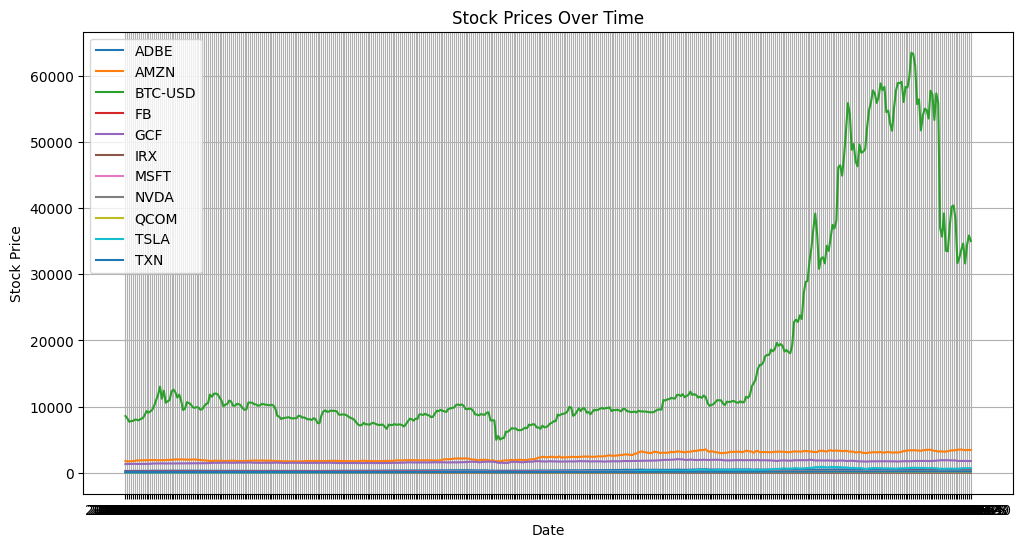

In [21]:
plt.figure(figsize=(12, 6))
x = stock_table.reset_index()
for column in stock_table.columns[1:]:
    plt.plot(x["Date"], stock_table[column], label=column)

plt.title("Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()
plt.show()

In [10]:
data = stock_table

returns = data.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [11]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [12]:
def portfolio_return(weights, mean_returns):
    return np.dot(weights.T, mean_returns)

In [13]:
def objective_function(weights, mean_returns, cov_matrix, target_return):
    risk = portfolio_variance(weights, cov_matrix)
    exp_return = portfolio_return(weights, mean_returns)
    penalty = 1000 * max(0, target_return - exp_return)
    return risk + penalty

In [14]:
def constraint_sum_weights(weights):
    return np.sum(weights) - 1

In [22]:
bounds = tuple((0, 1) for _ in range(len(mean_returns)))
initial_weights = np.array([1/len(mean_returns)] * len(mean_returns))
constraints = [
    {'type': 'eq', 'fun': constraint_sum_weights}
]

In [23]:
target_return = 0.001 

result = minimize(
    objective_function,
    initial_weights,
    args=(mean_returns, cov_matrix, target_return),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x
print("Optimal Weights:", optimal_weights)

portfolio_risk = np.sqrt(portfolio_variance(optimal_weights, cov_matrix))
portfolio_exp_return = portfolio_return(optimal_weights, mean_returns)

print("Portfolio Expected Return:", portfolio_exp_return)
print("Portfolio Risk:", portfolio_risk)

Optimal Weights: [2.17406668e-02 2.45662507e-18 1.88211852e-01 8.67361738e-19
 7.36562037e-02 5.93719574e-01 9.64930664e-04 5.42193145e-02
 5.76344170e-18 0.00000000e+00 0.00000000e+00 6.74874583e-02]
Portfolio Expected Return: 0.0012061275288278504
Portfolio Risk: 0.01153992127109705


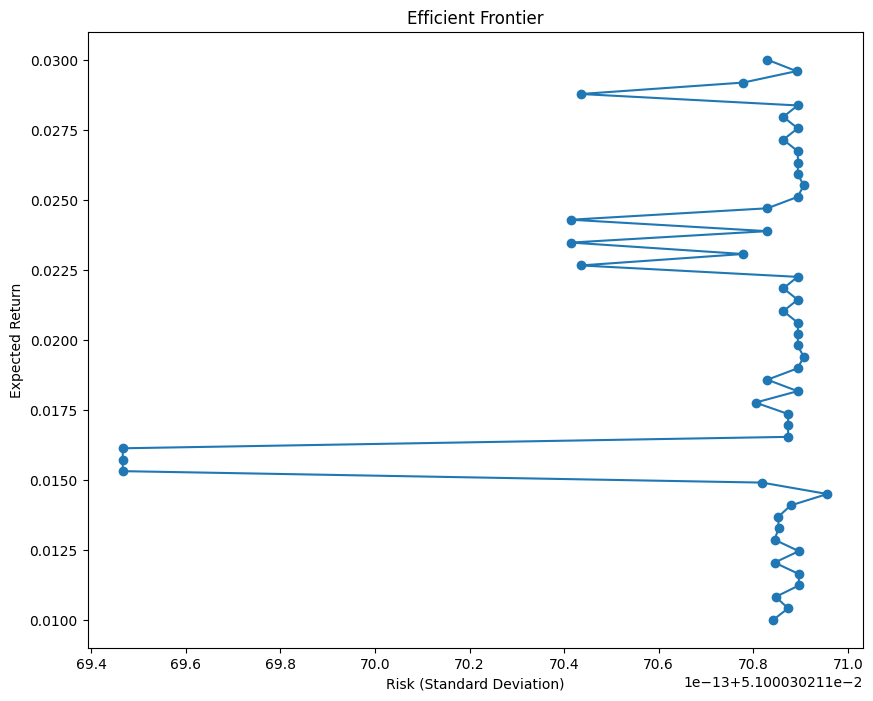

In [29]:
target_returns = np.linspace(0.01, 0.03, 50)  
risks = []

for r in target_returns:
    res = minimize(
        objective_function,
        initial_weights,
        args=(mean_returns, cov_matrix, r),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    risks.append(np.sqrt(portfolio_variance(res.x, cov_matrix)))

plt.figure(figsize=(10, 8))
plt.plot(risks, target_returns, marker='o')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()